# Detection of COVID-19 in X-Ray Images (COVID-19 vs. Normal)

##### Notebook settings

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Prerequisites

##### Import libraries

In [2]:
!pip install -q adversarial-robustness-toolbox
from art.utils import load_dataset
from art.attacks.inference import model_inversion 
from art.estimators.classification import KerasClassifier
from art.estimators.classification import TensorFlowV2Classifier

     |████████████████████████████████| 983kB 8.0MB/s 
     |████████████████████████████████| 3.4MB 30.3MB/s 
     |████████████████████████████████| 25.3MB 1.5MB/s 


In [41]:
import os, random
import numpy as np
import seaborn as sns
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

import keras
from keras.optimizers import Adam
from keras.models import Sequential
from keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.experimental.preprocessing import Resizing, Rescaling, RandomFlip, RandomRotation, RandomTranslation, RandomZoom
from keras.layers import Layer, InputLayer, Conv2D, Activation, Add, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, ZeroPadding2D, Flatten

##### Define constants

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Model parameters
BATCH_SIZE = 32 # test 128
IMG_SHAPE = [28, 28, 1] # dataset image size is 28x28x1
EPOCHS = 20

# Set fixed random seed
seed = 42
np.random.seed(seed)
random.seed(seed)
random_state = 42

In [5]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset(str('mnist'))

In [51]:
def dpnet_builder():
    # create DP-Net
    dpnet = tf.compat.v1.keras.Sequential([
        tf.compat.v1.keras.layers.Input(shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])),
        tf.compat.v1.keras.layers.Conv2D(filters=16, kernel_size=(8,8), strides=2, padding='same', activation='relu'),
        tf.compat.v1.keras.layers.BatchNormalization(),
        tf.compat.v1.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.compat.v1.keras.layers.Conv2D(filters=32, kernel_size=(4,4), strides=2, padding='same', activation='relu'),
        tf.compat.v1.keras.layers.BatchNormalization(),
        tf.compat.v1.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.compat.v1.keras.layers.Flatten(),
        tf.compat.v1.keras.layers.Dense(units=32, activation='relu'),
        tf.compat.v1.keras.layers.BatchNormalization(),
        tf.compat.v1.keras.layers.Dense(units=10, activation='softmax'),
    ])
    return dpnet

In [52]:
dpnet = dpnet_builder()

METRICS = [
    'accuracy',
]

dpnet.compile(
    optimizer='adam', # default: lr=1e-3
    loss='categorical_crossentropy',
    metrics=METRICS
)

In [53]:
art_classifier = KerasClassifier(clip_values=(0, 1),
                                 model=dpnet, use_logits=False)

In [54]:
art_classifier.fit(x_train, y_train, nb_epochs=1, batch_size=BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training_v1.py:1246: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


1875/1875 [==============================] - 13s 6ms/step - batch: 937.0000 - size: 32.0000 - loss: 0.1928 - accuracy: 0.9474


In [55]:
predictions = art_classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Accuracy on benign test examples: 97.19%


In [56]:
def perform_inversion(classifier, init='white', max_iter=10000, lr=0.1, pred_cutoff=1.0, average_data=None, nb_classes=1):
    # create inversion attack
    attack = model_inversion.MIFace(classifier,
                                    max_iter=max_iter,
                                    threshold=pred_cutoff,
                                    learning_rate=lr)
    
    # init inference image
    if init == 'white':
        x_init = np.ones((IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2]))
    elif init == 'black':
        x_init = np.zeros((IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2]))
    elif init == 'grey':
        x_init = np.zeros((IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])) + 0.5
    elif init == 'random':
        x_init = np.random.uniform(0, 1, (IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2]))
    elif init == 'average':
        x_init = np.zeros((IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])) + np.mean(average_data, axis=0)

    y = np.arange(nb_classes)

    # plot initial image
    plt.imshow(np.squeeze(x_init, axis=2), cmap='gray')
    plt.axis('off')
    plt.title('Initial '+init+' inversion image')
    plt.show()
    print("Prediction - %a" % (classifier.predict(np.expand_dims(x_init, axis=0), training_mode=False)))

    x_init_batch = np.array([x_init for i in range(nb_classes)])

    # ensure that the classifier's gradients are non-vanishing for each target class
    # attack won't work if the classifier's gradients are vanishin
    class_gradient = classifier.class_gradient(x_init_batch, y)
    class_gradient = np.reshape(class_gradient, (nb_classes, IMG_SHAPE[0] * IMG_SHAPE[1] * IMG_SHAPE[2]))
    class_gradient_max = np.max(class_gradient, axis=1)

    print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))

    # run the attack
    x_infer = attack.infer(x_init_batch, y)
    
    # plot inferred images
    def show_inferred(image_batch):
        plt.figure(figsize=(15,15))
        for n in range(10):
            ax = plt.subplot(2, 5, n+1)
            plt.imshow(np.squeeze(image_batch[n], axis=2), cmap='gray')
            plt.axis("off")
        plt.show()

    print('Final '+init+' inversion images')
    show_inferred(x_infer)
    #print("Prediction - %.4f" % (classifier.predict(np.expand_dims(img, axis=0), training_mode=False))[0][i])

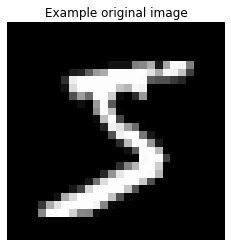

Prediction - array([[1.8064475e-04, 2.9886312e-06, 4.1764427e-04, 2.7075318e-01,
        2.0203527e-04, 7.2536188e-01, 3.4669260e-04, 2.2447605e-04,
        2.0973512e-03, 4.1311132e-04]], dtype=float32)


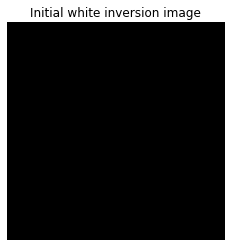

Prediction - array([[7.1209781e-02, 1.3620429e-03, 9.4909118e-03, 1.5551584e-04,
        4.1634891e-02, 3.8646124e-04, 1.1349807e-01, 5.5611767e-05,
        6.8185204e-01, 8.0354638e-02]], dtype=float32)
Minimum over all maximum class gradient: 0.000015



Final white inversion images


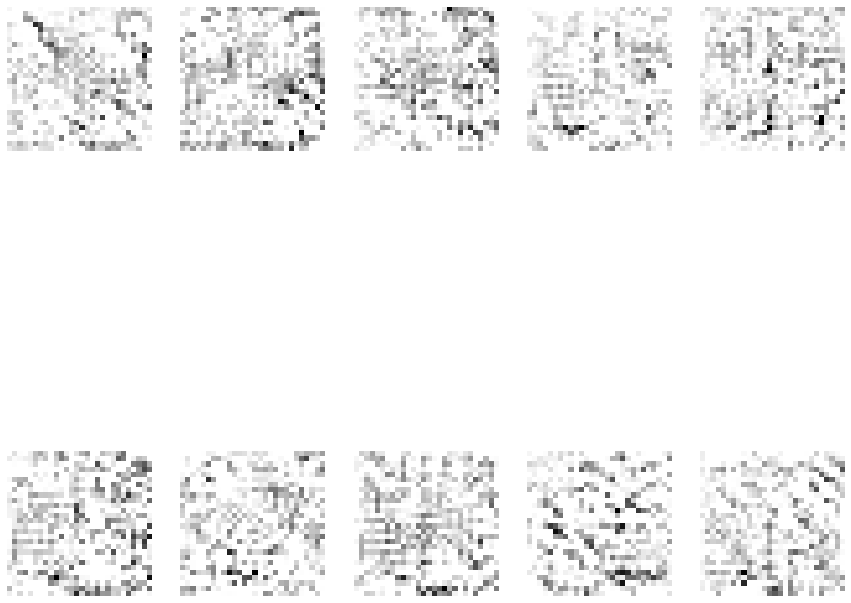

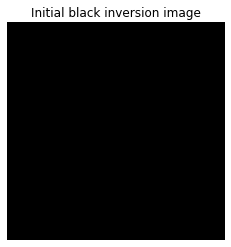

Prediction - array([[7.6060331e-09, 1.9966683e-06, 9.9996603e-01, 9.9344655e-10,
        4.2559266e-20, 3.1209993e-08, 1.0045239e-14, 2.8895745e-05,
        2.8920351e-06, 3.2918138e-08]], dtype=float32)
Minimum over all maximum class gradient: 0.000000



Final black inversion images


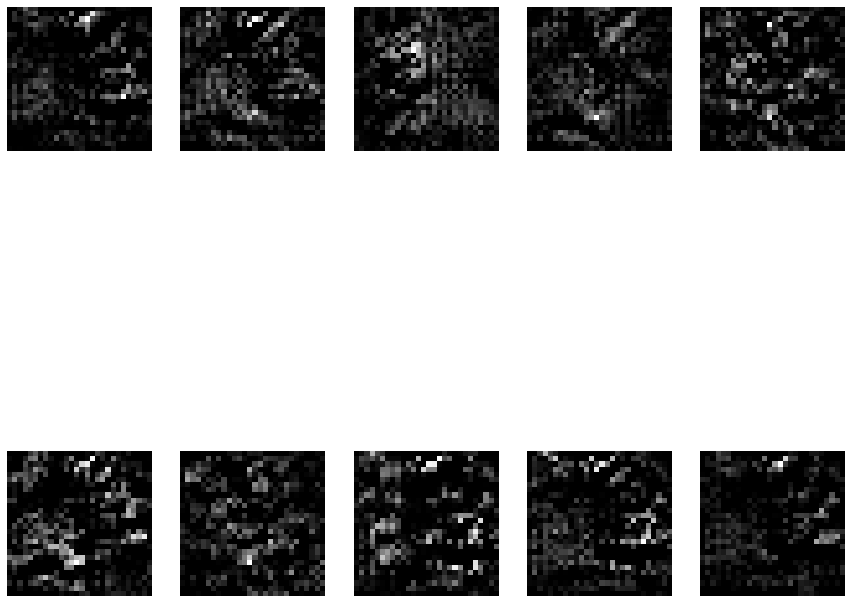

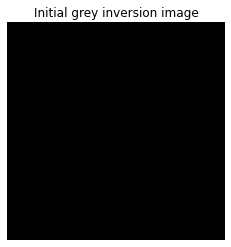

Prediction - array([[6.6686453e-06, 5.2625616e-04, 2.3670096e-02, 1.3016956e-04,
        2.1275053e-08, 9.7309607e-01, 2.3550205e-03, 6.1838401e-09,
        1.9639166e-04, 1.9260951e-05]], dtype=float32)
Minimum over all maximum class gradient: 0.000000



Final grey inversion images


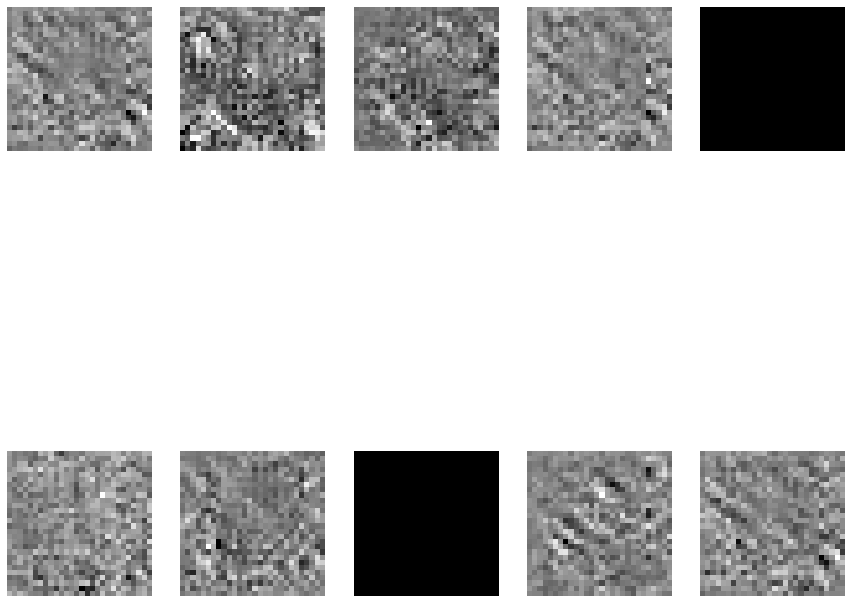

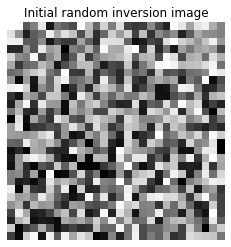

Prediction - array([[4.74554226e-02, 1.20335538e-03, 7.30542606e-03, 2.73638288e-04,
        1.15828991e-01, 1.05290569e-03, 6.99691847e-02, 2.25703508e-04,
        6.53604150e-01, 1.03081174e-01]], dtype=float32)
Minimum over all maximum class gradient: 0.000083



Final random inversion images


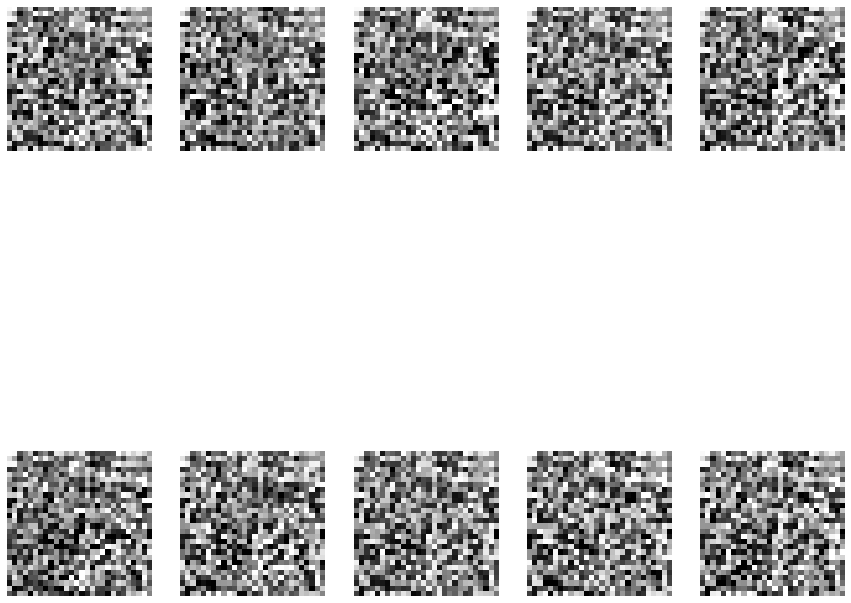

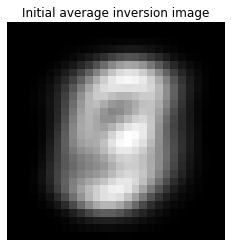

Prediction - array([[1.4084450e-02, 9.0996377e-02, 2.1752189e-01, 6.4977715e-03,
        3.8435915e-05, 6.2780017e-01, 2.4933703e-02, 1.2468138e-04,
        1.3599413e-02, 4.4031013e-03]], dtype=float32)
Minimum over all maximum class gradient: 0.000219



Final average inversion images


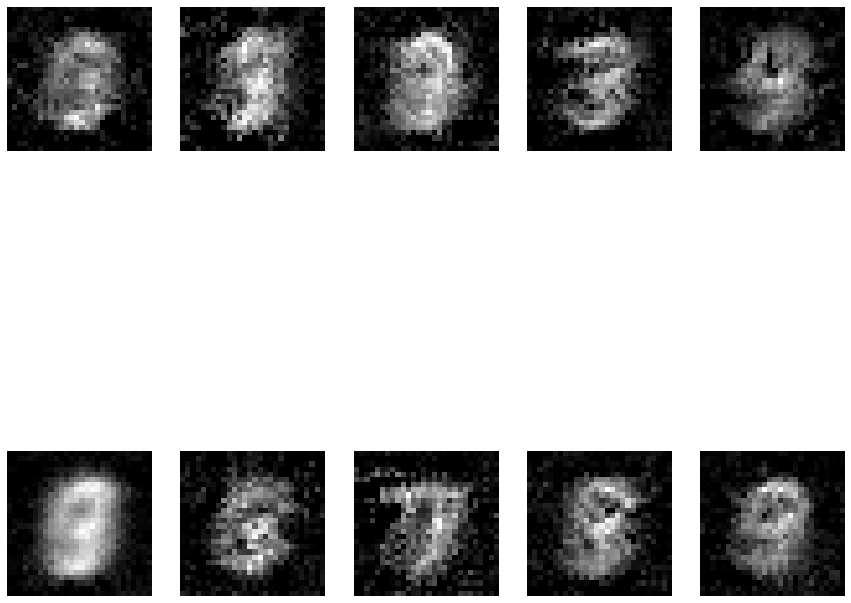

In [60]:
# example original image
plt.imshow(np.squeeze(x_train[0], axis=2), cmap='gray')
plt.axis('off')
plt.title('Example original image')
plt.show()
print("Prediction - %a" % (art_classifier.predict(np.expand_dims(x_train[0], axis=0), training_mode=False)))

inits = ['white', 'black', 'grey', 'random', 'average']
for init in inits:
    average_data = None if init != 'average' else x_train
    perform_inversion(classifier=art_classifier,
                    init=init,
                    max_iter=1000,
                    lr=0.1,
                    pred_cutoff=1.0,
                    average_data=average_data,
                    nb_classes=10)

## Data


### Load dataset

In [ ]:
(train_ds, test_ds), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
TRAIN_IMG_COUNT = ds_info.splits['train'].num_examples
TEST_IMG_COUNT = ds_info.splits['test'].num_examples
print(
    'Train: ' + str(TRAIN_IMG_COUNT) + ',',
    'Test: ' + str(TEST_IMG_COUNT),
)

Train: 60000, Test: 10000


### Prepare for training

###### Define preprocessing and data augmentation

In [ ]:
preprocessing = tf.keras.Sequential([
  Resizing(IMG_SHAPE[0], IMG_SHAPE[1]),
  Rescaling(scale=1./255)
])

In [ ]:
# implemented as keras layers below but kept for overview
datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range=(0.85, 1.15),
        brightness_range=(0.9, 1.1),
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        fill_mode='constant',
        cval=0.,)

In [ ]:
class RandomBrightness(Layer):
  def __init__(self, factor=0.1, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return tf.image.random_brightness(x, max_delta=self.factor)

In [ ]:
data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.1, fill_mode='constant'),
  RandomTranslation(0.1, 0.1, fill_mode='constant'),
  RandomZoom(0.15, fill_mode='constant'),
  RandomBrightness(0.1),
])

###### Prepare datasets for use

In [ ]:
def prepare_dataset(ds, cache=True, pre=False, shuffle=False, repeat=False, batch=False, augment=False, shuffle_buffer_size=1000):
    # give string to cache preprocessing for datasets outside of memory
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    # Resize and rescale images
    if pre:
        ds = ds.map(lambda x, y: (preprocessing(x), y),
                    num_parallel_calls=AUTOTUNE)
    # shuffle dataset
    if shuffle:
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # repeat set forever or once
    if repeat:
        ds = ds.repeat()
    else:
        ds = ds.repeat(1)
    # batch dataset
    if batch:
        if str(batch) == '1':
            ds = ds.batch(batch).prefetch(buffer_size=AUTOTUNE)
        else:
            ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    # use data augmentation
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    return ds

In [ ]:
# batch datasets
train_batched = prepare_dataset(train_ds,
                                pre=True,
                                shuffle=True,
                                repeat=True,
                                batch=True,
                                augment=False,
                                cache='./data.tfcache')
test_batched = prepare_dataset(test_ds,
                               pre=True,
                               shuffle=False,
                               repeat=False,
                               batch=True,
                               augment=False)

In [ ]:
# seperate train labels and images for attacks
train_unbatched= prepare_dataset(train_ds,
                                 pre=True,
                                 shuffle=True,
                                 repeat=False,
                                 batch=False,
                                 augment=False,
                                 cache=False)
x_train_attack = prepare_dataset(train_unbatched,
                                 pre=False,
                                 shuffle=False,
                                 repeat=False,
                                 batch=1, # TODO batching needed?
                                 augment=False)
y_train_attack = []
for x, y in tf.data.Dataset.as_numpy_iterator(train_unbatched):
    y_train_attack.append(y)

# seperate test labels and images for attacks
test_unbatched = prepare_dataset(test_ds,
                                 pre=True,
                                 shuffle=False,
                                 repeat=False,
                                 batch=False,
                                 augment=False,
                                 cache=False)
x_test_attack = prepare_dataset(test_unbatched,
                                pre=False,
                                shuffle=False,
                                repeat=False,
                                batch=1, # TODO batching needed?
                                augment=False)
x_test_attack2 = []
y_test_attack = []
for x, y in tf.data.Dataset.as_numpy_iterator(test_unbatched):
    x_test_attack2.append(x)
    y_test_attack.append(y)

### Visualization

###### Images from a training batch

In [ ]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(5,5))
    img_num = 9 if BATCH_SIZE > 9 else BATCH_SIZE
    for n in range(img_num):
        ax = plt.subplot(np.log(img_num) / np.log(2), np.log(img_num) / np.log(2), n+1)
        plt.imshow(np.squeeze(image_batch[n], axis=2), cmap='gray')
        plt.axis("off")

In [ ]:
image_batch, label_batch = next(iter(train_batched))

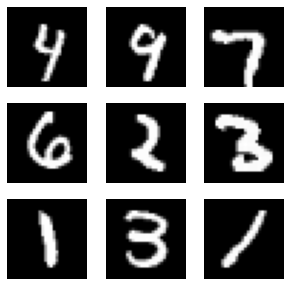

In [ ]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Tuning

### Learning rate decay

In [ ]:
learning_rate_decay = ReduceLROnPlateau(monitor='loss', patience=2, factor=0.1, min_lr=1e-6)

## DP-Net - CNN Archecture for DP-SGD
Based on [Paper 1](https://arxiv.org/abs/2007.14191)
\([Paper 2](https://openreview.net/forum?id=rJg851rYwH)\)
[Paper BN](https://arxiv.org/pdf/2006.10919.pdf)

### Model definition

In [ ]:
def dpnet_builder():
    # create DP-Net
    dpnet = Sequential([
        InputLayer(input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])),
        Conv2D(filters=16, kernel_size=(8,8), strides=2, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(filters=32, kernel_size=(4,4), strides=2, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(units=32, activation='relu'),
        BatchNormalization(),
        Dense(units=10, activation='sigmoid'),
    ])
    return dpnet

In [ ]:
dpnet = dpnet_builder()

METRICS = [
    'accuracy',
]

dpnet.compile(
    optimizer=Adam(lr=1e-3), # default: 1e-3
    loss=SparseCategoricalCrossentropy(),
    metrics=METRICS
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
dpnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 16)        1040      
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 32)          8224      
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 32)          128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0

### Training

In [ ]:
history_dpnet = dpnet.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT//BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[learning_rate_decay],
)

Epoch 1/20
1875/1875 [==============================] - 46s 7ms/step - loss: 0.4298 - accuracy: 0.8759
Epoch 2/20
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0725 - accuracy: 0.9781
Epoch 3/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0552 - accuracy: 0.9828
Epoch 4/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0448 - accuracy: 0.9862
Epoch 5/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0386 - accuracy: 0.9879
Epoch 6/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0339 - accuracy: 0.9891
Epoch 7/20
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0287 - accuracy: 0.9904
Epoch 8/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0260 - accuracy: 0.9914
Epoch 9/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0235 - accuracy: 0.9925
Epoch 10/20
1875/1875 [==============================] - 12s 6ms/step - l

### Evaluation

###### Visualize performance

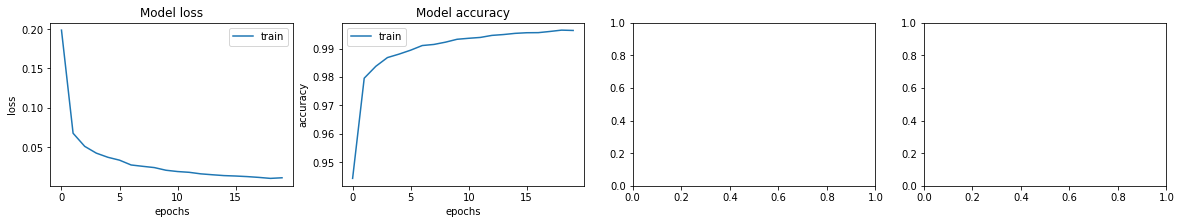

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy']):
    ax[i].plot(history_dpnet.history[met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train'])

###### Predict on test set

In [ ]:
loss, acc = dpnet.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")

313/313 [==============================] - 2s 4ms/step - loss: 0.0476 - accuracy: 0.9878
Loss of the model is -  0.04760781675577164
Accuracy of the model is -  98.78000020980835 %


## Privacy

### Compute epsilon

In [ ]:
# delta rule of thumb: set to less than the inverse of the training data size
DELTA = 1e-5

In [ ]:
# computes epsilon for given hyperparameters
def compute_epsilon(n, batch_size, noise_multiplier, epochs, delta):
    if noise_multiplier == 0.0:
        return float('inf')
    sampling_probability = batch_size / n
    steps = int(np.ceil(epochs * n / batch_size))
    orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))
    rdp = compute_rdp(
        q = sampling_probability,
        noise_multiplier = noise_multiplier,
        steps = steps,
        orders = orders)
    return get_privacy_spent(orders, rdp, target_delta=delta)[0]

In [ ]:
NOISE_MULTIPLIER = 0.0
eps = compute_epsilon(
    TRAIN_IMG_COUNT,
    BATCH_SIZE,
    NOISE_MULTIPLIER,
    EPOCHS,
    DELTA)
print('Delta = %.e, Epsilon = %.3f'%(DELTA, eps))

Delta = 1e-05, Epsilon = inf


### Attacks

###### Model Inversion Attack

In [ ]:
def perform_inversion(classifier, init='white', max_iter=10000, lr=0.1, pred_cutoff=1.0, average_data=None, nb_classes=1):
    # create inversion attack
    attack = model_inversion.MIFace(classifier,
                                    max_iter=max_iter,
                                    threshold=pred_cutoff,
                                    learning_rate=lr)
    
    # init inference image
    if init == 'white':
        x_init = np.ones((IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2]))
    elif init == 'black':
        x_init = np.zeros((IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2]))
    elif init == 'grey':
        x_init = np.zeros((IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])) + 0.5
    elif init == 'random':
        x_init = np.random.uniform(0, 1, (IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2]))
    elif init == 'average':
        x_init = np.zeros((IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])) + np.mean(average_data, axis=0)

    y = np.arange(nb_classes)

    # plot initial image
    plt.imshow(np.squeeze(x_init, axis=2), cmap='gray')
    plt.axis('off')
    plt.title('Initial '+init+' inversion image')
    plt.show()
    print("Prediction - %a" % (classifier.predict(np.expand_dims(x_init, axis=0), training_mode=False)))

    x_init_batch = np.array([x_init for i in range(nb_classes)])

    # ensure that the classifier's gradients are non-vanishing for each target class
    # attack won't work if the classifier's gradients are vanishin
    class_gradient = classifier.class_gradient(x_init_batch, y)
    class_gradient = np.reshape(class_gradient, (nb_classes, IMG_SHAPE[0] * IMG_SHAPE[1] * IMG_SHAPE[2]))
    class_gradient_max = np.max(class_gradient, axis=1)

    print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))

    # run the attack
    x_infer = attack.infer(x_init_batch, y)
    
    # plot inferred images
    def show_inferred(image_batch):
        plt.figure(figsize=(15,15))
        for n in range(10):
            ax = plt.subplot(2, 5, n+1)
            plt.imshow(np.squeeze(image_batch[n], axis=2), cmap='gray')
            plt.axis("off")
        plt.show()

    print('Final '+init+' inversion images')
    show_inferred(x_infer)
    #print("Prediction - %.4f" % (classifier.predict(np.expand_dims(img, axis=0), training_mode=False))[0][i])

In [ ]:
# create classifier for attacks
art_classifier = TensorFlowV2Classifier(model=dpnet,
                                        nb_classes=10,
                                        input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2]),
                                        loss_object=SparseCategoricalCrossentropy(),
                                        clip_values=(0, 1))

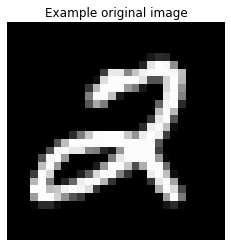

Prediction - array([[0.31309232, 0.05052304, 1.        , 0.05520066, 0.01061772,
        0.01264067, 0.01189337, 0.4096579 , 0.99043274, 0.02142995]],
      dtype=float32)


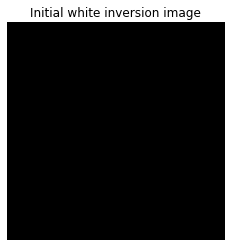

Prediction - array([[9.7620583e-01, 8.4126122e-02, 9.9460405e-01, 1.9942582e-04,
        7.2267747e-01, 9.7971961e-02, 9.9926907e-01, 2.2480609e-02,
        5.7656699e-01, 4.0971231e-02]], dtype=float32)


Minimum over all maximum class gradient: 0.000154



Final white inversion images


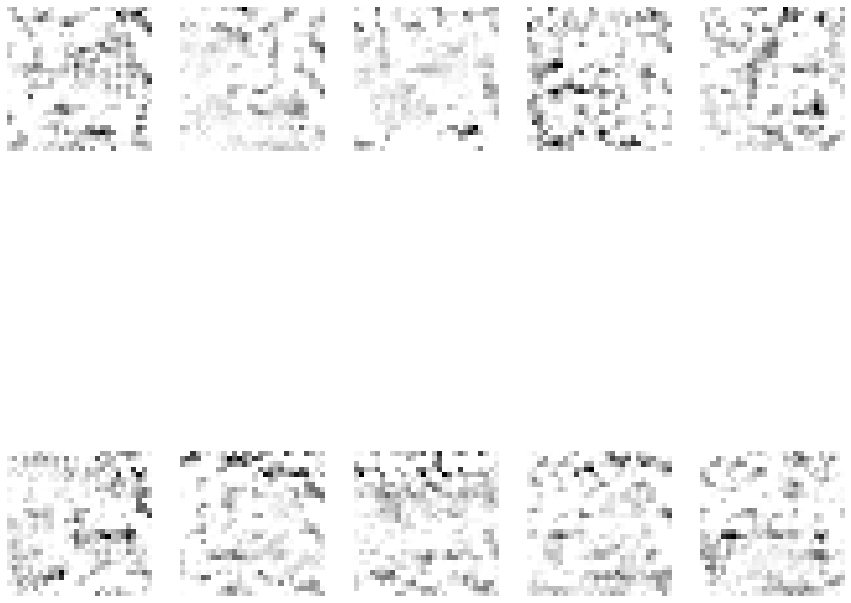

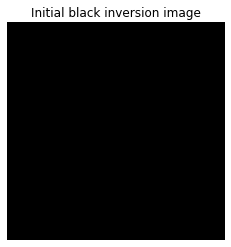

Prediction - array([[7.3306985e-08, 6.2065845e-07, 1.0000000e+00, 1.6970115e-13,
        1.0000000e+00, 8.8851774e-01, 1.0000000e+00, 1.0000000e+00,
        1.0000000e+00, 1.0000000e+00]], dtype=float32)
Minimum over all maximum class gradient: 0.000000



Final black inversion images


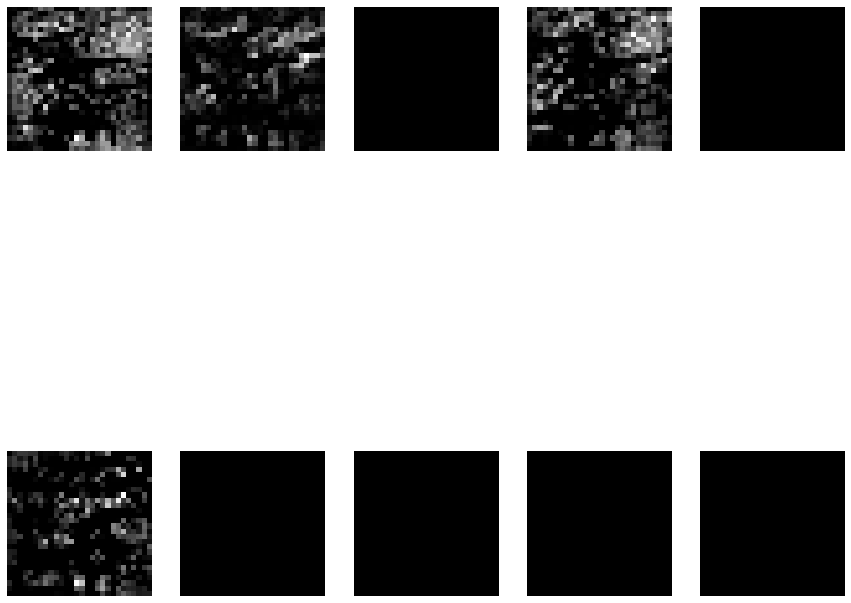

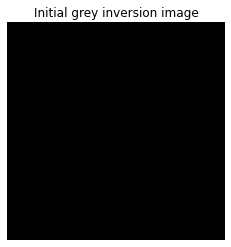

Prediction - array([[9.44473028e-01, 4.17340279e-01, 6.83984756e-01, 6.04627121e-06,
        6.23577498e-02, 1.49783850e-01, 9.89429533e-01, 1.65591948e-03,
        4.52141374e-01, 1.10550396e-01]], dtype=float32)
Minimum over all maximum class gradient: 0.000005


In [ ]:
# example original image
plt.imshow(np.squeeze(x_test_attack2[0], axis=2), cmap='gray')
plt.axis('off')
plt.title('Example original image')
plt.show()
print("Prediction - %a" % (art_classifier.predict(np.expand_dims(x_test_attack2[0], axis=0), training_mode=False)))

inits = ['white', 'black', 'grey', 'random', 'average']
for init in inits:
    average_data = None if init != 'average' else x_test_attack2
    perform_inversion(classifier=art_classifier,
                    init=init,
                    max_iter=10000,
                    lr=0.1,
                    pred_cutoff=1.0,
                    average_data=average_data,
                    nb_classes=10)